## Storytelling: What the Data Reveals

- **Popularity Insights**: Indian videos tend to show a larger number of "Neutral" or "Positive" sentiments in both titles and tags. This suggests a generally more uplifting tone in trending content.

- **Category Trends**: Certain categories such as Music and Entertainment trend more often and receive significantly higher views.

- **Temporal Trends**: Trending activity shows visible spikes on specific dates — possibly weekends, holidays, or major events.

- **Audience Behavior**: The sentiment associated with video tags aligns with how the video is promoted or optimized for search — affecting click-through rates.

This analysis helps us understand viewer preferences, sentiment distribution, and content performance in regional markets.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
title=None
xlabel=None
ylabel=None
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\AK\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
us_df=pd.read_csv("USvideos.csv")
in_df=pd.read_csv("INvideos.csv")

us_df["country"]="US"
in_df["country"]="India"

df=pd.concat([us_df,in_df],ignore_index=True)
df.shape

(78301, 17)

In [33]:
df["trending_date"]=pd.to_datetime(df["trending_date"],format="%y.%d.%m")
df["publish_time"]=pd.to_datetime(df["publish_time"])
df["publish_date"]=df["publish_time"].dt.date
df=df.drop(["video_id","thumbnail_link","desccription"],axis=1,errors="ignore")
df['tags']=df['tags'].fillna('')

In [34]:
sid = SentimentIntensityAnalyzer()
df['title_sentiment']=df['title'].apply(lambda x:sid.polarity_scores(str(x))['compound'])
df['title_sentiment_label']=df['title_sentiment'].apply(lambda x: "Positive" if x>0.05 else "Negative" if x < -0.05 else "Neutral")

df["tags_sentiment"]=df["tags"].apply(lambda x:sid.polarity_scores(str(x))['compound'])
df['tags_sentiment_label']=df["tags_sentiment"].apply(lambda x:"Positive" if x>0.05 else "Negative" if x < -0.05 else "Neutral")


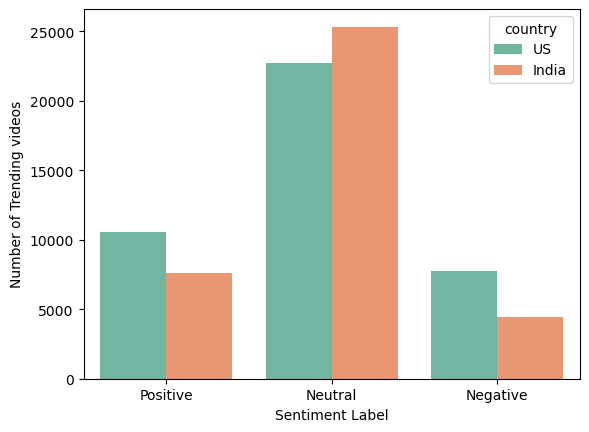

In [24]:
sns.countplot(data=df,
x='title_sentiment_label',hue='country',palette='Set2')
plt.title=('Title Sentiment Distribution by Country')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Trending videos')
plt.show()

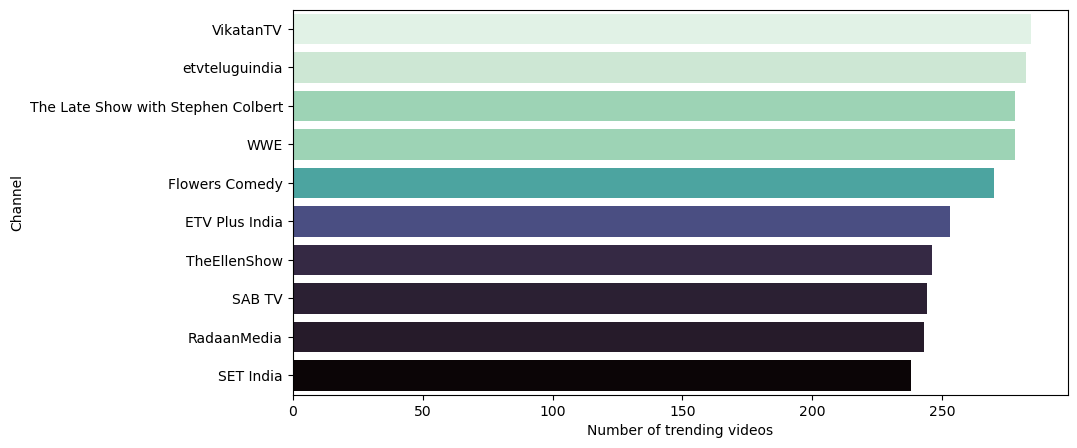

In [25]:
top_channels=df['channel_title'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_channels.values,y=top_channels.index,hue=top_channels,legend=False,palette='mako')
plt.title='Top 10 Trending channels (India + USA)'
plt.xlabel("Number of trending videos")
plt.ylabel("Channel")
plt.show()

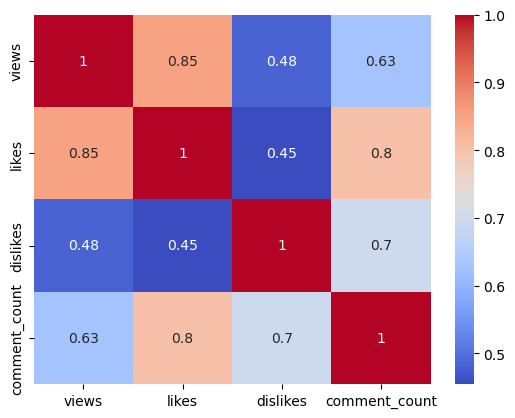

In [26]:
numeric_cols=['views','likes','dislikes','comment_count']
correlation=df[numeric_cols].corr()
sns.heatmap(correlation,annot=True,cmap='coolwarm')
plt.title ="Correlation between Views,Likes,Dislikes and comments"
plt.show()

In [27]:
df['publish_time']=pd.to_datetime(df['publish_time'],utc=True).dt.tz_localize(None)
df['trending_date']=pd.to_datetime(df['trending_date'])
df['days_to_trend']=(df['trending_date']-df['publish_time']).dt.days

df_clean=df[(df['days_to_trend']>=0)&(df['days_to_trend']<=60)].copy()

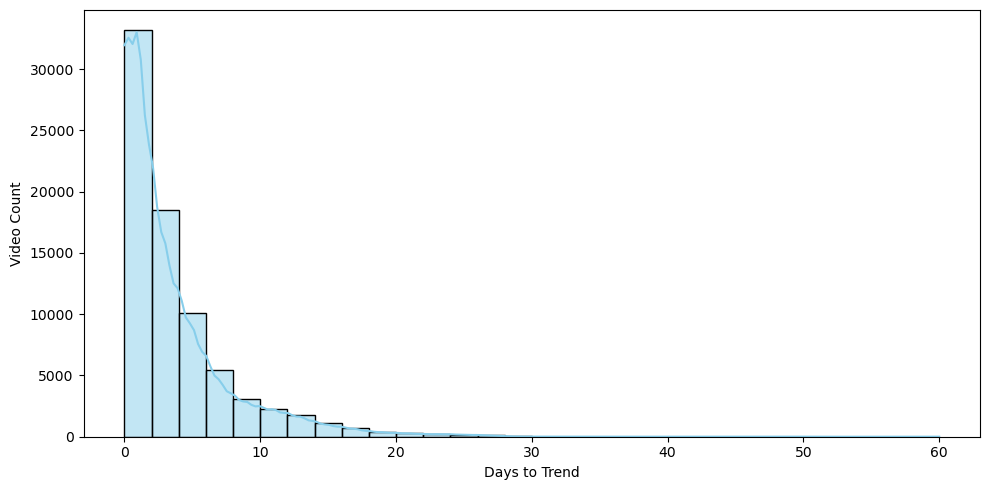

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.histplot(data=df_clean,x='days_to_trend',bins=30,kde=True,color='skyblue')
plt.title="Days from publish to trending"
plt.xlabel("Days to Trend")
plt.ylabel("Video Count")
plt.tight_layout()
plt.show()

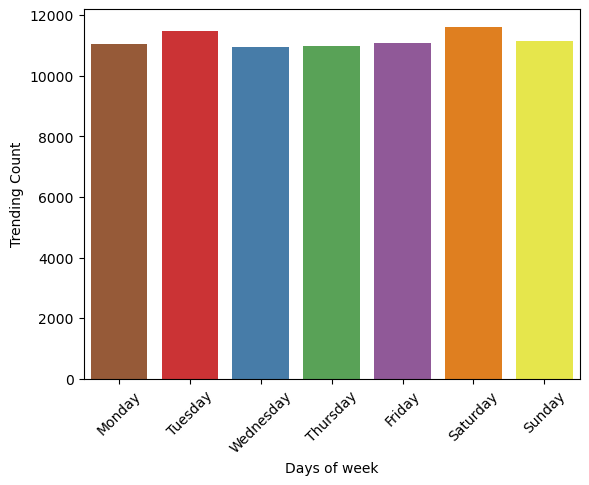

In [29]:
df['trending_weekday']=df['trending_date'].dt.day_name()
sns.countplot(data=df,x='trending_weekday',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],palette='Set1',legend=False,hue='trending_weekday')
plt.title="Trending Days by Weekday"
plt.xlabel("Days of week")
plt.ylabel("Trending Count")
plt.xticks(rotation=45)
plt.show()

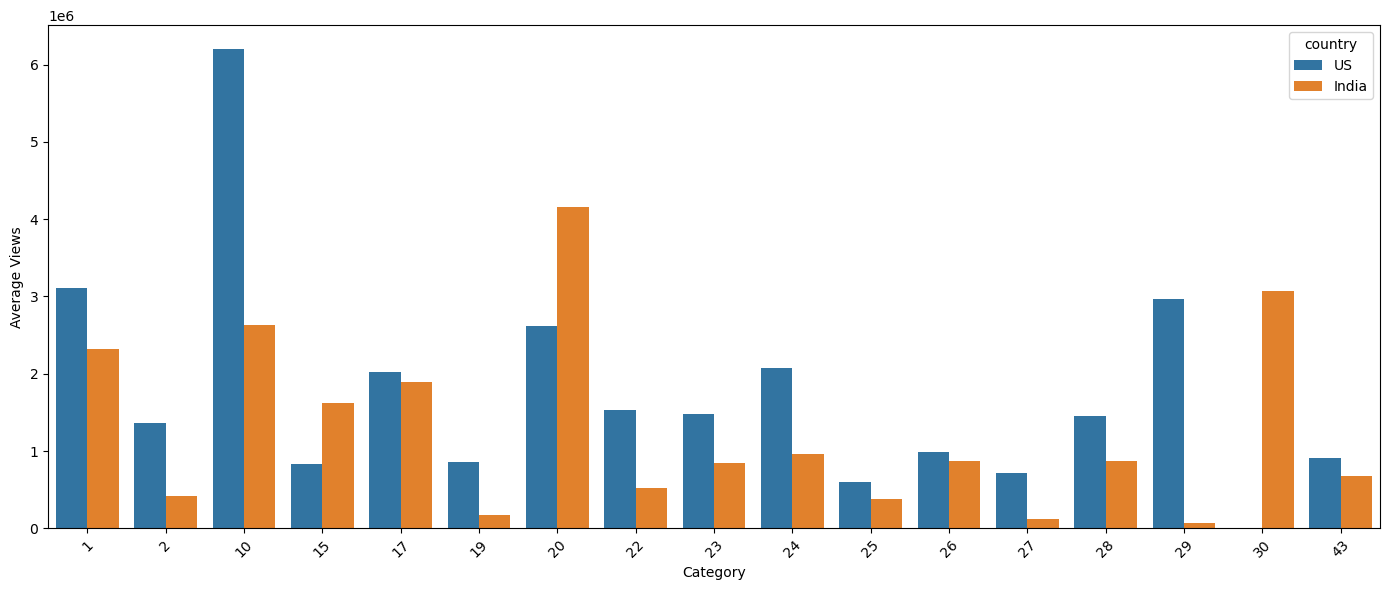

In [30]:

category_views = df.groupby(['country', 'category_id'])['views'].mean().reset_index().sort_values(by='views', ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(data=category_views, x='category_id', y='views', hue='country')
plt.xticks(rotation=45)
plt.title='Average Views per Category by Country'
plt.ylabel('Average Views')
plt.xlabel('Category')
plt.tight_layout()
plt.show()


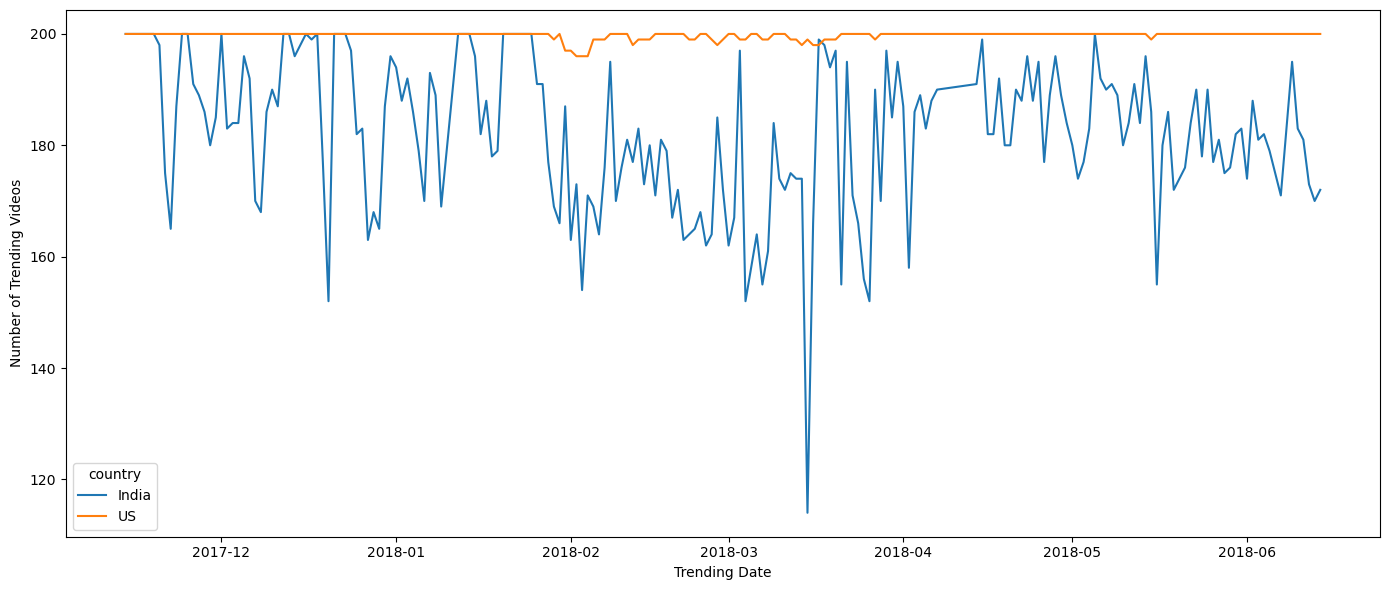

In [31]:
trend_time = df.groupby(['trending_date', 'country']).size().reset_index(name='video_count')

plt.figure(figsize=(14,6))
sns.lineplot(data=trend_time, x='trending_date', y='video_count', hue='country')
plt.title='Number of Trending Videos Over Time'
plt.xlabel('Trending Date')
plt.ylabel('Number of Trending Videos')
plt.tight_layout()
plt.show()


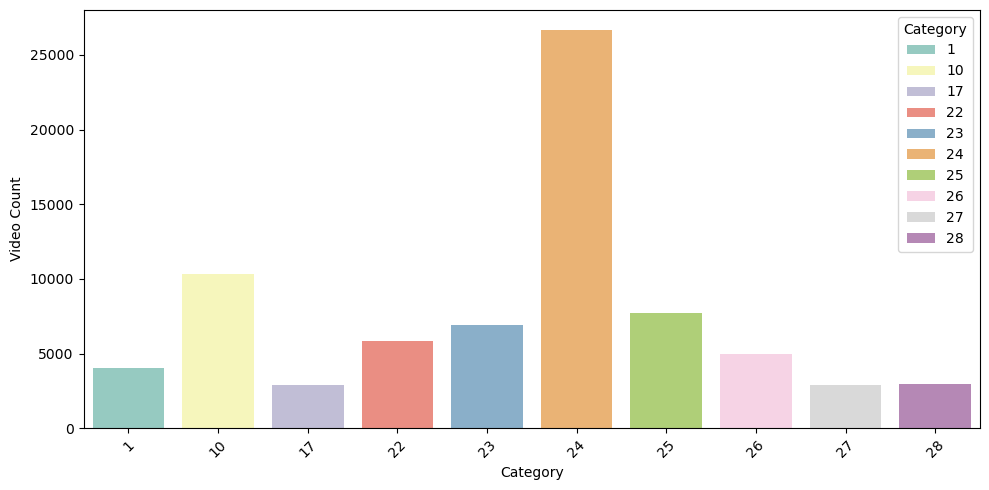

In [32]:
top_categories = df['category_id'].value_counts().head(10).reset_index()
top_categories.columns = ['Category', 'Video Count']

plt.figure(figsize=(10,5))
sns.barplot(data=top_categories, x='Category', y='Video Count', palette='Set3',hue='Category')
plt.title='Top 10 Most Trending Categories'
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
